## Preparation

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data_dir = 'D:\DATASETS\For-Thesis\Labels'

In [3]:
def sample_count(data_dir):
    for dir in os.listdir(data_dir):
        print("{}: {}".format(dir, len(os.listdir(os.path.join(data_dir,dir)))))

In [4]:
sample_count(data_dir)

Building: 600
Plant: 600
Road: 600
Vehicle: 600


## Prepare Dataset

In [5]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [6]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0
y_one_hot = tf.keras.utils.to_categorical(y_label_idx)

In [7]:
y_one_hot[0]

array([1., 0., 0., 0.], dtype=float32)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_one_hot))
dataset = dataset.shuffle(buffer_size=dataset.cardinality(), seed=1).batch(8)

In [9]:
dataset_iter = dataset.as_numpy_iterator()

In [10]:
batch = dataset_iter.next()

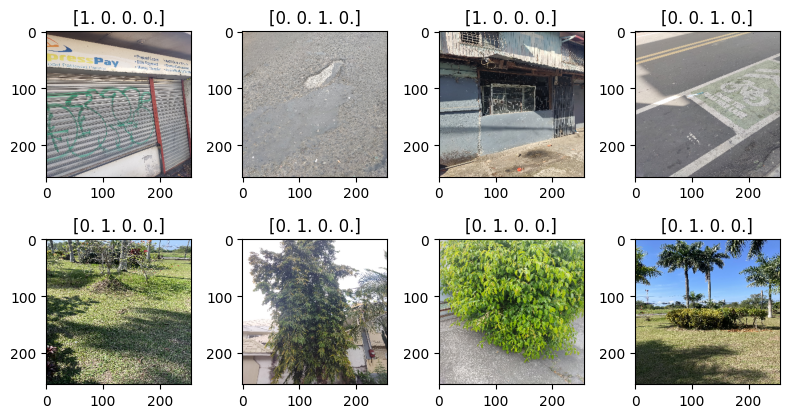

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(8,4.5))
for idx, ax_idx in enumerate(itertools.product(range(2),range(4))):
    ax[ax_idx].imshow(batch[0][idx].astype(float))
    ax[ax_idx].title.set_text(batch[1][idx])
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

In [12]:
total_batch_count = len(dataset) 
train_batch_count = total_batch_count // 4 * 3  # 75% of batches
test_batch_count = total_batch_count - train_batch_count
print(total_batch_count , train_batch_count, test_batch_count)

300 225 75


In [13]:
train_size, test_size = train_batch_count, test_batch_count
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size).take(test_size)

In [14]:
train_set, val_set = tf.keras.utils.split_dataset(dataset=train_set, left_size=0.75, shuffle=True, seed=1)

## Make Model

In [22]:
model = Sequential()
model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
model.add(RandomRotation(factor=0.2, seed=1))

model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2, seed=1))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=64,activation="relu"))

model.add(Dense(units=4, activation="softmax"))


In [23]:
optimizer = tf.keras.optimizers.Adam(weight_decay=0.0005)

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)     

In [25]:
file_name = 'Model_V4-0-5_' + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'./logs/{file_name}'
checkpoint_filepath = f'./checkpoints/{file_name}'

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                             histogram_freq=1,
                                             profile_batch=2,
                                             write_graph=True,
                                             write_images=True,
                                             update_freq='epoch',
                                             embeddings_freq=1
                                            )
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
#                                                patience=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_accuracy', 
                                                         mode='auto', 
                                                         save_best_only=True, 
                                                         verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.3, 
                                                 patience=2, 
                                                 min_delta=0.001, 
                                                 mode='auto', 
                                                 verbose=1)

## Train and Inspect Model

In [26]:
hist = model.fit(train_set, 
                 validation_data=val_set, 
                 epochs30,
                 verbose=1,
                 callbacks=[tb_callback, cp_callback, reduce_lr])
                 # callbacks=[tb_callback, es_callback, cp_callback, reduce_lr])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 2.5044 - accuracy: 0.5614
Epoch 1: val_accuracy improved from -inf to 0.25670, saving model to ./checkpoints\Model_V4-0-5_20240302-131640
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


169/169 [==============================] - 50s 273ms/step - loss: 2.5044 - accuracy: 0.5614 - val_loss: 2.9242 - val_accuracy: 0.2567 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 0.8594 - accuracy: 0.6923
Epoch 2: val_accuracy improved from 0.25670 to 0.66741, saving model to ./checkpoints\Model_V4-0-5_20240302-131640
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


169/169 [==============================] - 46s 270ms/step - loss: 0.8594 - accuracy: 0.6923 - val_loss: 0.8337 - val_accuracy: 0.6674 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 0.6503 - accuracy: 0.7522
Epoch 3: val_accuracy improved from 0.66741 to 0.72545, saving model to ./checkpoints\Model_V4-0-5_20240302-131640
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


169/169 [==============================] - 56s 332ms/step - loss: 0.6503 - accuracy: 0.7522 - val_loss: 0.6420 - val_accuracy: 0.7254 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7825
Epoch 4: val_accuracy improved from 0.72545 to 0.73214, saving model to ./checkpoints\Model_V4-0-5_20240302-131640
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


169/169 [==============================] - 45s 268ms/step - loss: 0.5613 - accuracy: 0.7825 - val_loss: 0.6708 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.7877
Epoch 5: val_accuracy did not improve from 0.73214
169/169 [==============================] - 42s 249ms/step - loss: 0.5361 - accuracy: 0.7877 - val_loss: 1.3515 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.7973
Epoch 6: val_accuracy did not improve from 0.73214

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
169/169 [==============================] - 42s 247ms/step - loss: 0.5342 - accuracy: 0.7973 - val_loss: 0.8284 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 7/30
169/169 [==============================] - ETA: 0s - loss: 0.4107 - accuracy: 0.8462
Epoch 7: val_accuracy improved from 0.73214 to 0.83482, saving model to ./checkpoints\Model_

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


169/169 [==============================] - 45s 266ms/step - loss: 0.4107 - accuracy: 0.8462 - val_loss: 0.4414 - val_accuracy: 0.8348 - lr: 3.0000e-04
Epoch 8/30
169/169 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.8632
Epoch 8: val_accuracy did not improve from 0.83482
169/169 [==============================] - 40s 235ms/step - loss: 0.3676 - accuracy: 0.8632 - val_loss: 0.4905 - val_accuracy: 0.8237 - lr: 3.0000e-04
Epoch 9/30
169/169 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8735
Epoch 9: val_accuracy did not improve from 0.83482

Epoch 9: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
169/169 [==============================] - 40s 238ms/step - loss: 0.3234 - accuracy: 0.8735 - val_loss: 0.4301 - val_accuracy: 0.8281 - lr: 3.0000e-04
Epoch 10/30
169/169 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8942
Epoch 10: val_accuracy improved from 0.83482 to 0.84821, saving model to ./chec

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


169/169 [==============================] - 45s 269ms/step - loss: 0.2697 - accuracy: 0.8942 - val_loss: 0.4220 - val_accuracy: 0.8482 - lr: 9.0000e-05
Epoch 11/30
169/169 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8994
Epoch 11: val_accuracy improved from 0.84821 to 0.87054, saving model to ./checkpoints\Model_V4-0-5_20240302-131640
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_20240302-131640\assets


169/169 [==============================] - 45s 268ms/step - loss: 0.2682 - accuracy: 0.8994 - val_loss: 0.3802 - val_accuracy: 0.8705 - lr: 9.0000e-05
Epoch 12/30
169/169 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.8994
Epoch 12: val_accuracy did not improve from 0.87054
169/169 [==============================] - 40s 239ms/step - loss: 0.2652 - accuracy: 0.8994 - val_loss: 0.4119 - val_accuracy: 0.8661 - lr: 9.0000e-05
Epoch 13/30
169/169 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9112
Epoch 13: val_accuracy did not improve from 0.87054

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
169/169 [==============================] - 40s 238ms/step - loss: 0.2458 - accuracy: 0.9112 - val_loss: 0.3924 - val_accuracy: 0.8683 - lr: 9.0000e-05
Epoch 14/30
169/169 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.9061
Epoch 14: val_accuracy did not improve from 0.87054
169/169 [=============

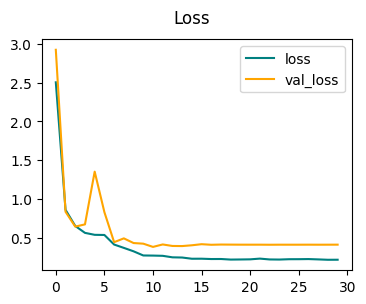

In [27]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()

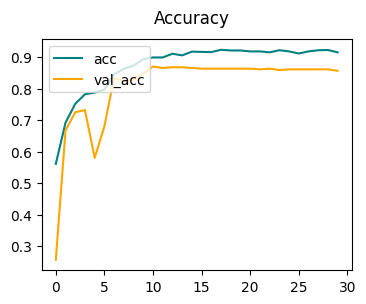

In [28]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['accuracy'], color='teal', label='acc')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
plt.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

### Evaluate Last Case of Model

In [29]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [30]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)

1/1 [==============================] - 0s 94ms/step


In [31]:
def print_scores(f1, pre, rec, c_acc):
    f1_score = f1.result().numpy() * 100
    pre_score = pre.result().numpy() * 100
    rec_score = rec.result().numpy() * 100
    c_acc_score = c_acc.result().numpy() * 100
    print(f"Precision: {pre_score:.2f}")
    print(f"Recall: {rec_score:.2f}")
    print(f"Categorical Accuracy: {c_acc_score:.2f}")
    print("F1 Score: ", f1_score)

In [32]:
print_scores(f1, pre, rec, c_acc)

Precision: 87.10
Recall: 85.50
Categorical Accuracy: 86.33
F1 Score:  [77.8157   89.49153  94.405594 84.04907 ]


## More Visualization (Tensorboard)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

In [ ]:
test_log = 'logs/test'
img_dir = "D:\\DATASETS\\Car-Plant-House-Road-Dataset\\Sample-Thesis-Dataset\\2.png"

file_writer = tf.summary.create_file_writer(test_log)
img = image_to_numpy.load_image_file(os.path.join(img_dir))
img = cv2.resize(img, (256, 256))
img = np.reshape(img, (-1, 256, 256, 3))

In [ ]:
# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Training data", img, step=0)

In [ ]:
# AppData/Local/Temp/.tensorboard-info - delete folder if it cannot load
%tensorboard --logdir=logs/

## Load Best Model from Checkpoint and Evaluate

In [242]:
saved_model = tf.keras.models.load_model("checkpoints\\Model_V4-0-5_20240302-131640")

In [243]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)     

In [244]:
best_result = saved_model.evaluate(test_set, return_dict=True, verbose=2)
print(best_result)

75/75 - 4s - loss: 0.3481 - accuracy: 0.8883 - 4s/epoch - 56ms/step
{'loss': 0.34813645482063293, 'accuracy': 0.8883333206176758}


In [245]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [246]:
test_images = []
test_labels = []
test_preds = [] 

In [247]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = saved_model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)
    
    for i in range(len(y)):
        test_images.append(X[i])
        test_labels.append(y[i])
        test_preds.append(yhat[i])

1/1 [==============================] - 0s 98ms/step


In [248]:
print_scores(f1, pre, rec, c_acc)

Precision: 90.14
Recall: 88.33
Categorical Accuracy: 89.67
F1 Score:  [82.706764 90.84746  95.00001  89.028206]


## Visualize Misclassified Images

In [249]:
test_images_c = np.array(test_images)

test_labels_c = [np.argmax(x) for x in test_labels]
test_labels_c = np.array(test_labels_c)

test_preds_c = [np.argmax(x) for x in test_preds]
test_preds_c = np.array(test_preds_c)

In [250]:
test_labels_c[:10]

array([1, 0, 0, 1, 3, 3, 2, 0, 2, 3], dtype=int64)

In [251]:
test_labels[:10]

[array([0., 1., 0., 0.], dtype=float32),
 array([1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 1., 0.], dtype=float32),
 array([1., 0., 0., 0.], dtype=float32),
 array([0., 0., 1., 0.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32)]

###  Plotting Confusion Matrix 

In [252]:
cm = sklearn.metrics.confusion_matrix(test_labels_c, test_preds_c)

Text(0.5, 1.0, 'Confusion Matrix')

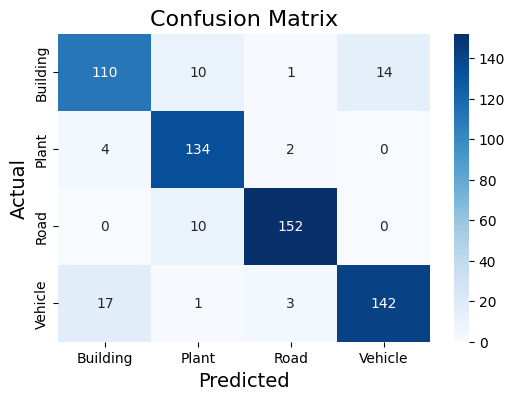

In [253]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=True,
            xticklabels=['Building', 'Plant', 'Road', 'Vehicle'],
            yticklabels=['Building', 'Plant', 'Road', 'Vehicle'],
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

### Visualize Misclassified Images

In [254]:
misclassified = test_labels_c - test_preds_c

In [255]:
mis_idx = np.where(misclassified != 0)

In [256]:
m = np.squeeze(mis_idx)

In [257]:
def toClasses(x):
    if x == 0:
        return 'Building'
    if x == 1:
        return 'Plant'
    if x == 2:
        return 'Road'
    if x == 3:
        return 'Vehicle'

In [258]:
toClasses_vectorized = np.vectorize(toClasses)

In [259]:
test_label_names = toClasses_vectorized(test_labels_c)
test_pred_names = toClasses_vectorized(test_preds_c)

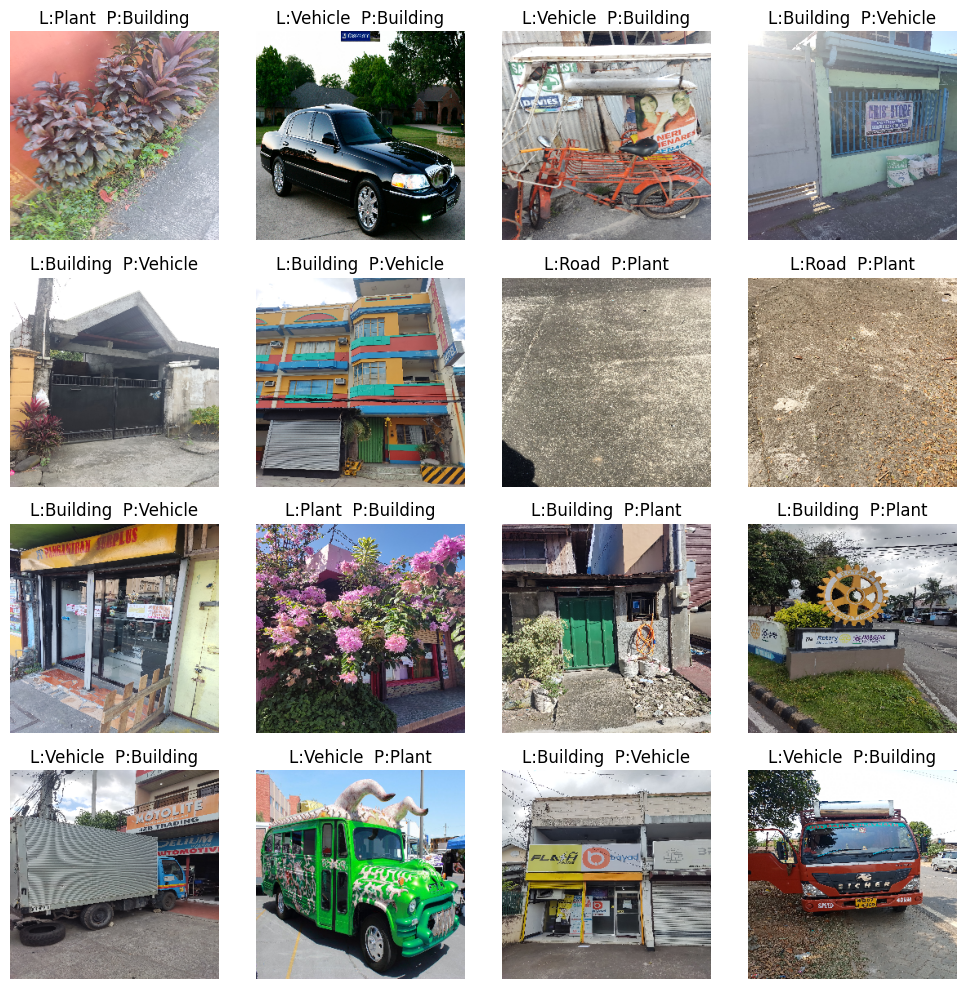

In [263]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for idx, ax_idx in enumerate(itertools.product(range(4), range(4))):
    ax[ax_idx].imshow(test_images_c[m[idx]].astype(float))
    ax[ax_idx].title.set_text(f'L:{test_label_names[m[idx]]}  P:{test_pred_names[m[idx]]}' )
    ax[ax_idx].axis('off')
fig.tight_layout()

## Save Model For API

In [ ]:
# saved_model = tf.keras.models.load_model('checkpoints\\Model_V4-0-0')

In [264]:
saved_model.save("models/Model_V4-0-5_20240302-131640.keras")

## See what the model sees

In [ ]:
saved_model.summary()

In [ ]:
len(saved_model.layers)

In [ ]:
layers_c1 = saved_model.layers[:6]
model_c1 = Sequential(layers_c1)
model_c1.summary()

In [ ]:
img_sample_dir = "D:\\DATASETS\\For-Thesis\\From Other Datasets\\Stanford-Car-Dataset\\cars_train\\cars_train\\00006.jpg"

In [ ]:
model_c1.input_shape

In [ ]:
image_size = 256
img_sample = image_to_numpy.load_image_file(os.path.join(img_sample_dir))
img_sample = cv2.resize(img_sample, (image_size, image_size))
img_sample = img_sample.astype(np.float32) / 255.0

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img_sample.astype(float))

In [ ]:
output_c1 = model_c1.predict(np.expand_dims(img_sample, 0))

In [ ]:
output_c1[0,:,:,0].shape

In [ ]:
def viz_grid(output, ncols=4, nrows=4):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    # itertools.product creates a permutation 
    for idx, ax_idx in enumerate(list(itertools.product(range(ncols), range(nrows)))):
        ax[ax_idx[1], ax_idx[0]].imshow(output[0,:,:,idx])

In [ ]:
viz_grid(output_c1, 4, 4)

In [ ]:
layers_c2 = saved_model.layers[:10]
model_c2 = Sequential(layers_c2)
model_c2.summary()

In [ ]:
output_c2 = model_c2.predict(np.expand_dims(img_sample, 0))

In [ ]:
viz_grid(output_c2, 4, 4)

In [ ]:
layers_c3 = saved_model.layers[:14]
model_c3 = Sequential(layers_c3)
model_c3.summary()

In [ ]:
output_c3 = model_c3.predict(np.expand_dims(img_sample, 0))
output_c3.shape

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(15,15))
# itertools.product creates a permutation 
for idx, ax_idx in enumerate(list(itertools.product(range(4), range(8)))):
    ax[ax_idx[1], ax_idx[0]].imshow(output_c3[0,:,:,idx])
    
fig.tight_layout()

In [ ]:
yhat = saved_model.predict(np.expand_dims(img_sample, 0))

In [ ]:
# 0 is building
np.argmax(yhat)